# Streaming History EDA

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


hist_df = pd.read_csv('data/stream_hist_20_31_01__11_40_28.csv')

In [18]:
hist_df['endTime'] = pd.to_datetime(hist_df['endTime'])

hist_df['artistName'] = pd.Categorical(hist_df['artistName'])
hist_df['trackName'] = pd.Categorical(hist_df['trackName'])

In [19]:
min_date = hist_df['endTime'].dt.date.min()
max_date = hist_df['endTime'].dt.date.max()
print(f'Date range: {min_date} - {max_date}')

Date range: 2019-01-30 - 2020-01-30


## Most played artists

In [28]:
most_played = hist_df.groupby('artistName').agg({'msPlayed': [np.sum, np.size]})

cols = most_played.columns.to_flat_index()
cols = ['_'.join(c) for c in cols]
most_played.columns = cols

most_played = most_played.reset_index()
most_played.head()

,artistName,msPlayed_sum,msPlayed_size
0,$NOT,133668,2
1,$US VALENTINO,133141,1
2,$uicideBoy$,920427,7
3,*NSYNC,146724,1
4,*repeat repeat,187498,1


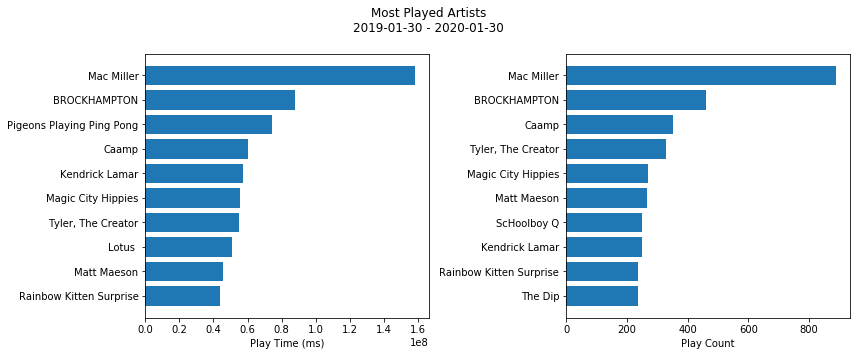

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

most_played = most_played.sort_values('msPlayed_sum', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[0].barh(plot_data['artistName'], plot_data['msPlayed_sum'])
axes[0].set_xlabel('Play Time (ms)')

most_played = most_played.sort_values('msPlayed_size', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[1].barh(plot_data['artistName'], plot_data['msPlayed_size'])
axes[1].set_xlabel('Play Count')

plt.suptitle(f'Most Played Artists\n{min_date} - {max_date}')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## Most played songs

In [52]:
hist_df['track_artist'] = (hist_df['trackName'].astype(str) + ' (' + 
                           hist_df['artistName'].astype(str) + ')')

hist_df['track_artist'] = pd.Categorical(hist_df['track_artist'])

In [53]:
most_played = hist_df.groupby('track_artist').agg({'msPlayed': [np.sum, np.size]})

cols = most_played.columns.to_flat_index()
cols = ['_'.join(c) for c in cols]
most_played.columns = cols

most_played = most_played.reset_index()
most_played.head()

,track_artist,msPlayed_sum,msPlayed_size
0,"""99"" (Barns Courtney)",944566,5
1,#SuperNicer (Exmag),1626,1
2,#W W C (The Main Squeeze),955106,6
3,$Dreams (Max Frost),214080,1
4,&Run (Sir Sly),1132935,5


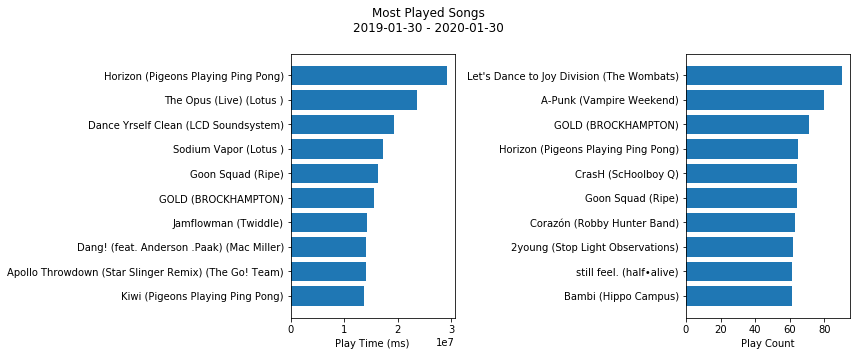

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

most_played = most_played.sort_values('msPlayed_sum', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[0].barh(plot_data['track_artist'], plot_data['msPlayed_sum'])
axes[0].set_xlabel('Play Time (ms)')

most_played = most_played.sort_values('msPlayed_size', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[1].barh(plot_data['track_artist'], plot_data['msPlayed_size'])
axes[1].set_xlabel('Play Count')

plt.suptitle(f'Most Played Songs\n{min_date} - {max_date}')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()